In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import scipy as sp

#Python/module versions used here for reference
print('Python: ', sys.version)
print('Matplotlib: ', mpl.__version__)
print('Pandas: ', pd.__version__)
print('Seaborn: ', sns.__version__)
print('SciPy: ', sp.__version__)

Python:  3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Matplotlib:  3.0.3
Pandas:  0.24.2
Seaborn:  0.9.0
SciPy:  1.2.1


# Voronoi Tesselation

Tracking data gives an unparalelled level of detail about the positioning of players and their control of space on the pitch. However, this data can also be difficult to work with and hard to interpret. One solution to these issues is to transform the data in ways that make it easier to analyse further. 

One such transformation is the Voronoi tesselation wherein the pitch is broken down into regions closest to each player. This pitch breakdown gives a rough estimate of the space a player or team has, or how this available space changes over time. Here, we demonstrate how to build a Voronoi tesselation using the existing Scipy implementation combined with one small trick.

## 1.  Data and setup

### Plotting a pitch

To help with visualisation we first define a basic pitch plotter using a slightly modified version of the code from [FCPython](https://fcpython.com/visualisation/drawing-pitchmap-adding-lines-circles-matplotlib).

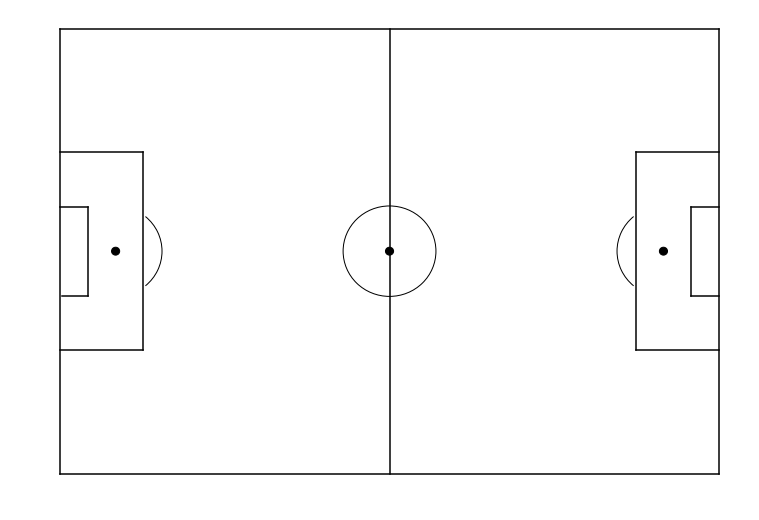

In [2]:
#Dimensions of the plotted pitch
max_h, max_w = 90, 130

#Creates the pitch plot an returns the axes.
def createPitch():
    #Create figure
    fig=plt.figure(figsize=(13,9))
    ax=plt.subplot(111)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,90], color="black")
    plt.plot([0,130],[90,90], color="black")
    plt.plot([130,130],[90,0], color="black")
    plt.plot([130,0],[0,0], color="black")
    plt.plot([65,65],[0,90], color="black")
    
    #Left Penalty Area
    plt.plot([16.5,16.5],[65,25],color="black")
    plt.plot([0,16.5],[65,65],color="black")
    plt.plot([16.5,0],[25,25],color="black")
    
    #Right Penalty Area
    plt.plot([130,113.5],[65,65],color="black")
    plt.plot([113.5,113.5],[65,25],color="black")
    plt.plot([113.5,130],[25,25],color="black")
    
    #Left 6-yard Box
    plt.plot([0,5.5],[54,54],color="black")
    plt.plot([5.5,5.5],[54,36],color="black")
    plt.plot([5.5,0.5],[36,36],color="black")
    
    #Right 6-yard Box
    plt.plot([130,124.5],[54,54],color="black")
    plt.plot([124.5,124.5],[54,36],color="black")
    plt.plot([124.5,130],[36,36],color="black")
    
    #Prepare Circles
    centreCircle = plt.Circle((65,45),9.15,color="black",fill=False)
    centreSpot = plt.Circle((65,45),0.8,color="black")
    leftPenSpot = plt.Circle((11,45),0.8,color="black")
    rightPenSpot = plt.Circle((119,45),0.8,color="black")
    
    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #Prepare Arcs
    leftArc = mpl.patches.Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
    rightArc = mpl.patches.Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    #Tidy Axes
    plt.axis('off')
    
    #Display Pitch
    return ax
    
#An example pitch
ax = createPitch()

### Data and Transformations
We begin by grabbing a single frame of x,y positions for 22 players that is in Tracab format. We then transform these positions to dimensions of the FCPython pitch.

In [3]:
#Five frames of tracking data in Tracab format
df = pd.read_csv('../data/tracab-like-frames.csv')

#The dimensions of the tracab pitch
data_w, data_h = 10500, 6800

#Pull the x/y coordinats for the home/away team
h_xs = df[[c for c in df.columns if 'H' in c and '_x' in c]].iloc[0].values
h_ys = df[[c for c in df.columns if 'H' in c and '_y' in c]].iloc[0].values
a_xs = df[[c for c in df.columns if 'A' in c and '_x' in c]].iloc[0].values
a_ys = df[[c for c in df.columns if 'A' in c and '_y' in c]].iloc[0].values

#This transforms the data to the plotting coords we use.
def transform_data(xs, ys, data_w, data_h, max_w, max_h):
    x_fix = lambda x : (x+data_w/2.)*(max_w / data_w)
    y_fix = lambda y : (y+data_h/2.)*(max_h / data_h)

    p_xs = list(map(x_fix, xs))
    p_ys = list(map(y_fix, ys))
    return p_xs, p_ys

#Home team xs and ys
h_xs, h_ys = transform_data(h_xs, h_ys, data_w, data_h, max_w, max_h)
#Away team xs and ys
a_xs, a_ys = transform_data(a_xs, a_ys, data_w, data_h, max_w, max_h)

### Plotting the players

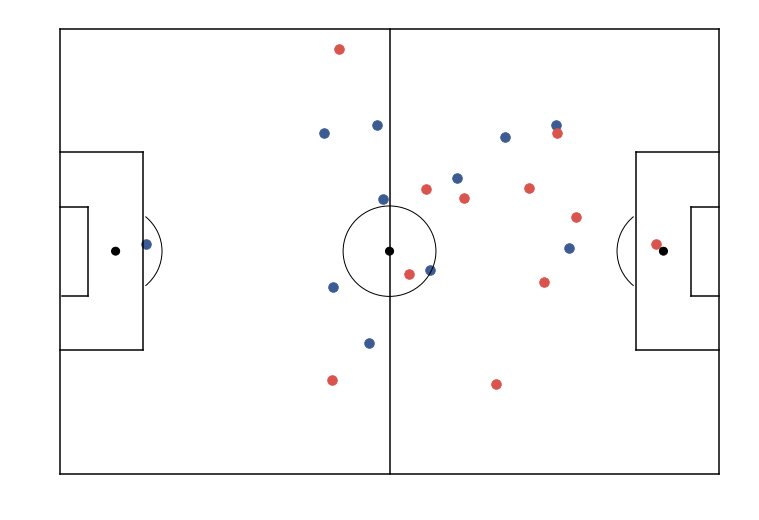

In [4]:
ax = createPitch()
ax.scatter(h_xs, h_ys, c='xkcd:denim blue', s=90.)
ax.scatter(a_xs, a_ys, c='xkcd:pale red', s=90.)

## 2. Voronoi Tesselation - First attempt

The hard work of performing a Voronoi tesselation is fortunately already implemented as part of the scipy package which means all we need to do is provide data in the correct form. There is also a plotting function to help visualise the Voronoi tesselation.

In [5]:
from scipy.spatial import Voronoi 

In [6]:
#Combined all of the players into a length 22 list of points
xs = h_xs+a_xs
ys = h_ys+a_ys
ps = [(x,y) for x,y in zip(xs, ys)]

#Perform the voronoi calculation, returns a scipy.spatial convex hull object
vor = Voronoi(ps)

Scipy.spatial provides a method that can plot a Voronoi tesselation onto provided axes. We can combine this with the plotting above to show the Voronoi tesselation of players

(-10, 100)

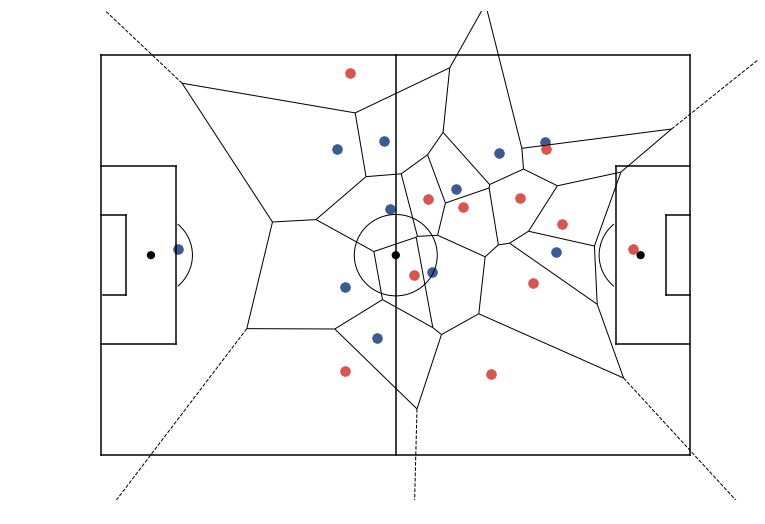

In [7]:
from scipy.spatial import voronoi_plot_2d
ax = createPitch()
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False)
ax.scatter(h_xs, h_ys, c='xkcd:denim blue', s=90.)
ax.scatter(a_xs, a_ys, c='xkcd:pale red', s=90.)
plt.xlim(-15,145)
plt.ylim(-10,100)

## 3. Problem - Dealing with pitch boundaries

The Voronoi tesselation algorithm doesn't know that we're looking at a bounded box (the pitch) when building the tesselation. As a result, the algorithm identifies polygons for some players with a vertex outside of the pitch. This is not ideal if we want to look at pitch control etc. Note also the dotted lines. These indicate those points equidistant from two players and go to infinity - also not ideal for a modelling football.

Rather than go back and try to build a Voronoi algorithm for ourselves that accounts for the bounded pitch we can use properties of the Voronoi algorithm to _trick_ it into putting the boundaries where we need them.

**The Trick:** By adding the reflection of all players about each of the four touchlines, each touchline necessarily becomes a the edge of a polygon found by the Voronoi algorithm.

By running the Voronoi algorithm on this extended set of points, and then throwing away all information about points that aren't actually players on the pitch, we end up with a Voronoi tesselation with polygons truncated by the touchlines. This is exactly what we need!

In [8]:
#Step 1 - Create a bigger set of points by reflecting the player points about all of the axes.
extended_ps = (ps +
                [(-p[0], p[1]) for p in ps] +       #Reflection in left touchline
                [(p[0], -p[1]) for p in ps] +       #Reflection in bottom touchline
                [(2*max_w-p[0], p[1]) for p in ps]+ #Reflection in right touchline
                [(p[0], 2*max_h-p[1]) for p in ps]  #Relfection in top touchline
              )

In [9]:
#Step 2 - Create a Voronoi tesselation for this extended point set
vor = Voronoi(extended_ps)

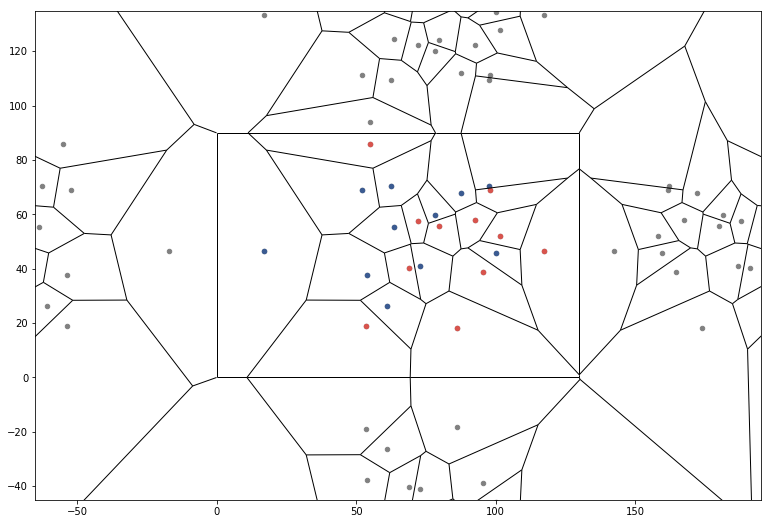

In [10]:
#Step 3 (Optional) - Check that the Voronoi tesselation works correctly and finds the pitch boundaries
# ax = createPitch()

fig=plt.figure(figsize=(13,9))
ax=plt.subplot(111)
e_xs, e_ys = zip(*extended_ps)

voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False, line_colors='k', zorder=0)
ax.scatter(e_xs, e_ys, c='grey', s=20.)
ax.scatter(h_xs, h_ys, c='xkcd:denim blue', s=20.)
ax.scatter(a_xs, a_ys, c='xkcd:pale red', s=20.)
plt.xlim(-0.5*max_w,1.5*max_w)
plt.ylim(-0.5*max_h,1.5*max_h);

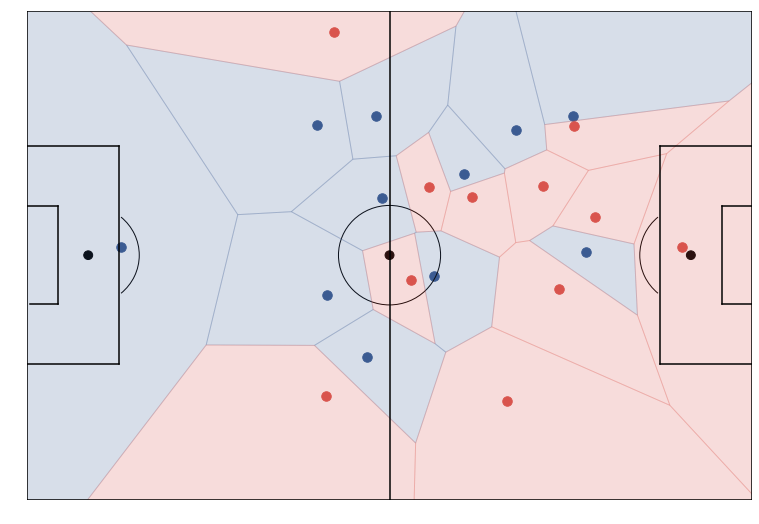

In [11]:
#Step 4 - Throw away the reflected points and their Voronoi polygons, then plot
ax = createPitch()

#Plot the Voronoi regions that contain the player points
for pix, p in enumerate(vor.points):                #Each polygon in the VT has a corresponding point
    region = vor.regions[vor.point_region[pix]]     #That point corresponds to a region
    if not -1 in region:                            #-1 is a point at infinity, we don't need those polygons
        polygon = [vor.vertices[i] for i in region] #The region polygon as a list of points
        if p[0] in xs and p[1] in ys:
            if p[0] in a_xs and p[1] in a_ys:
                plt.fill(*zip(*polygon), alpha=0.2, c='xkcd:pale red')
            else:
                plt.fill(*zip(*polygon), alpha=0.2, c='xkcd:denim blue')

#Add in the player points
ax.scatter(h_xs, h_ys, c='xkcd:denim blue', s=90.)
ax.scatter(a_xs, a_ys, c='xkcd:pale red', s=90.)
plt.xlim(0,max_w)
plt.ylim(0,max_h);